# Clasificación: Frutas
> Dataset disponible en https://www.kaggle.com/datasets/icebearogo/fruit-classification-dataset

Estoy bastante oxidado en temática de clasificación de imágenes. Así que iré desempolvando las técnicas de manipulación y clasificación de imágenes a la vez que afino mi conocimiento de programación en GPU. Aquí no aspiro a realizar ajuste de hiperparámetros.

In [1]:
import pandas as pd
from os import path

dataset_path = "./datasets/Fruit_dataset"

df_train = pd.read_csv(path.join(dataset_path, "train.csv"))
df_train.head()

,image:FILE,category
0,train/oil_palm/57.jpg,0
1,train/oil_palm/881.jpg,0
2,train/oil_palm/450.jpg,0
3,train/oil_palm/28.jpg,0
4,train/oil_palm/62.jpg,0


In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image:FILE  40000 non-null  object
 1   category    40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


Inspeccionando un poco las imágenes, el dataset no está tan sencillo como uno pensaría. Hay imágenes en fondo blanco, otras que no. Hay muchas frutas de colores similares, y entre una misma especie de frutas el color varía. No es sólo importante el color, sino también el contorno de la fruta.

Por otro lado, el dataset es muy extendo, siendo la cantidad de observaciones para el test de entrenamiento 40 mil. Aunque el dataset técnicamente cabe dentro de la memoria de mi GPU, sería interesante buscar técnicas de optimización para acelerar (potencialmente) el entrenamiento.

# Preparando el notebook para usar aceleración por GPU

In [3]:
# Estoy "inspirándome" del siguiente recurso: https://www.tensorflow.org/tutorials/images/classification
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-06-30 22:02:31.209525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751320951.257877   24043 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751320951.273939   24043 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751320951.618786   24043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751320951.618826   24043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751320951.618828   24043 computation_placer.cc:177] computation placer alr

In [4]:
tf.config.list_physical_devices('GPU')

2025-06-30 22:02:38.035185: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


[]

In [18]:
batch_size = 128
img_height = 180
img_width = 180

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path.join(dataset_path, 'train'),
    labels='inferred',
    validation_split=None,
    subset=None,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

eval_ds = tf.keras.utils.image_dataset_from_directory(
    path.join(dataset_path, 'val1'),
    labels='inferred',
    validation_split=None,
    subset=None,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 40000 files belonging to 100 classes.
Found 5000 files belonging to 100 classes.


In [41]:
class_names = train_ds.class_names
print(class_names)

['abiu', 'acai', 'acerola', 'ackee', 'ambarella', 'apple', 'apricot', 'avocado', 'banana', 'barbadine', 'barberry', 'betel_nut', 'bitter_gourd', 'black_berry', 'black_mullberry', 'brazil_nut', 'camu_camu', 'cashew', 'cempedak', 'chenet', 'cherimoya', 'chico', 'chokeberry', 'cluster_fig', 'coconut', 'corn_kernel', 'cranberry', 'cupuacu', 'custard_apple', 'damson', 'dewberry', 'dragonfruit', 'durian', 'eggplant', 'elderberry', 'emblic', 'feijoa', 'fig', 'finger_lime', 'gooseberry', 'goumi', 'grape', 'grapefruit', 'greengage', 'grenadilla', 'guava', 'hard_kiwi', 'hawthorn', 'hog_plum', 'horned_melon', 'indian_strawberry', 'jaboticaba', 'jackfruit', 'jalapeno', 'jamaica_cherry', 'jambul', 'jocote', 'jujube', 'kaffir_lime', 'kumquat', 'lablab', 'langsat', 'longan', 'mabolo', 'malay_apple', 'mandarine', 'mango', 'mangosteen', 'medlar', 'mock_strawberry', 'morinda', 'mountain_soursop', 'oil_palm', 'olive', 'otaheite_apple', 'papaya', 'passion_fruit', 'pawpaw', 'pea', 'pineapple', 'plumcot', '

# Visualiando el dataset

2025-06-30 21:57:23.080995: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


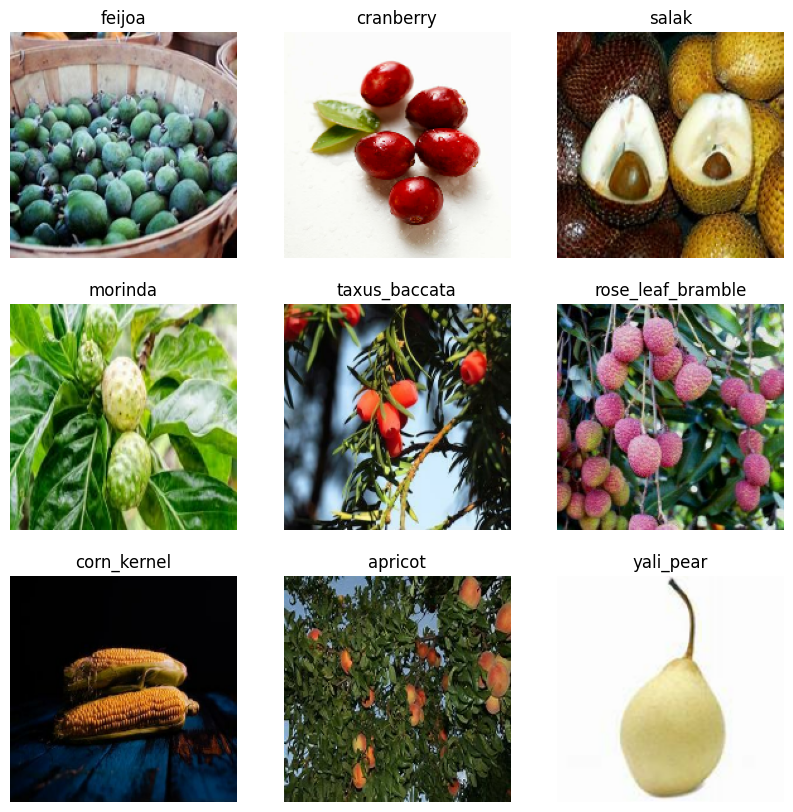

In [42]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Optimización del dataset

## Paso 1: Almacenamiento del dataset

Tensorflow ofrece dos formas de almacenar el dataset. Leyendo del artículo anteriormente citado:
> Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

> Dataset.prefetch overlaps data preprocessing and model execution while training.

En este caso, el dataset pesa ~600MB, y tengo espacio suficiente en memoria de GPU para almacenarlo, por lo que utilizaré `.cache` para garantizar que las operaciones I/O no sean un problema. En entornos con menor cantidad de memoria o dataset muy grandes `.prefetch` es una mejor elección.

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
eval_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Declaración del modelo

En primera instancia probaré con el modelo que sugiere la guía de Tensorflow.

In [44]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Capa de estandarización
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Inspeccionando más de cerca la clase Conv2D:
> This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

La convolución es una operación que permite transformar una región de la imagen a otra a partir de un kernel o filtro. Estos kernels son matriciales, y dado que la imagen es también una matriz, la aplicación del kernel consiste en la multiplicación matricial del kernel "sobre" los píxeles de la imagen. Esta multiplicación, realizada a lo largo y ancho de toda la imagen, es el resultado de la convolución.

Algunos tipos de kernel permiten capturar cambios de contraste o bordes, otros el color de las imágenes. La concatenación de los kernels correctos en la imagen será el elemento clave que permitirá extraer las características de la misma y, en este ejercicio, realizar la predicción de las frutas.

Como en todo ejercicio de machine learning, el mejor kernel será aquel que minimice el error en la predicción. Este es el trabajo de la red neuronal.

Después de toda esta explicación, los parámetros de esta clase son los siguientes:
+ `filters` (16): La cantidad de kernels a usar en dicha capa.
+ `kernel_size` (3): El tamaño de la matriz a usar. Cuando se pasa un entero se asume que la matriz es cuadrada.
+ `padding` (`'same'`): Añade bordes a la imagen antes de aplicar la convolución. Esto es útil para que el tamaño de la imagen de salida sea el mismo que el de la imagen de entrada. [Esta animación](https://miro.medium.com/v2/resize:fit:720/format:webp/1*oRmppyqA2jQFUCVEDHB6hQ.gif) (Axel Thevenot) permite visualizar mejor el efecto del padding.

MaxPooling2D se encarga de reducir la dimensionalidad sin perder información de la imagen generada. La idea es agregar información dispersa en varias secciones de una imagen en menos secciones con toda la información. La [siguiente imagen](https://en.wikipedia.org/wiki/Pooling_layer#/media/File:Convolutional_neural_network,_maxpooling.png) explica bien este concepto.

Todo esto sirve para explicar bien lo que está haciendo el modelo: Entrenar kernels para extraer las características relevantes de la imagen, capa por capa, aplicando pooling para reducir la dimensionalidad, agrupando la información de la imagen en sub-imágenes más pequeñas con la información concentradas.

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,001,540 (15.26 MB)

 Trainable params: 4,001,540 (15.26 MB)

 Non-trainable params: 0 (0.00 B)

Démosle play.

In [47]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=eval_ds,
  epochs=epochs
)

Epoch 1/10


2025-06-30 21:57:27.624334: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.
2025-06-30 21:57:28.004501: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2025-06-30 21:57:28.498690: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2025-06-30 21:57:28.953642: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2025-06-30 21:57:28.953732: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.


  3/313 ━━━━━━━━━━━━━━━━━━━━ 6:01 1s/step - accuracy: 0.0039 - loss: 4.7903    

KeyboardInterrupt: 